In [5]:
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram
from dotenv import dotenv_values
import pickle as pkl
import json
import openai
import time
import matplotlib.pyplot as plt
import numpy as np

In [6]:
config = dotenv_values(".env")  
openai.api_key = config['OPENAI_API_KEY']

In [7]:
with open("data/og/embeddings.json") as f:
    embeddings = json.load(f)

reverse_embeddings = {}
for i in range(len(embeddings.keys())):
    reverse_embeddings[tuple(list(embeddings.values())[i])] = list(embeddings.keys())[i]

with open("data/og/openai_summaries_2", "rb") as fp:
    summaries = pkl.load(fp)

with open('data/og/LinkageLabels2.pkl', 'rb') as f:
    linkage_labels = pkl.load(f)

with open('data/pca5_normalized.json') as f:
    pca5_normalized = json.load(f)

with open("data/real_linkage_labels.pkl", "rb") as fp:
    real_linkage_labels = pkl.load(fp)

In [8]:
summaries

{'Create a programming language.md': 'Technology-Talk',
 'Programming languages.md': 'Programming languages watchlist.',
 'Inspectional reading.md': 'Reading technique',
 'Reading philosophy.md': 'Philosophy styles.',
 'Reading imaginary.md': 'Reading techniques - Imaginary.',
 'Reading technics should differ depending on book type.md': 'Reading techniques.',
 'Elementary reading.md': 'Basic reading level.',
 'Re-reading books.md': 'Book Re-Reading.',
 'Evaluate a book.md': 'Reading evaluation.',
 'Syntopical reading.md': 'Reading level: Syntopical. \nSubject focus: Comparative analysis.',
 'The four levels of reading.md': 'Active reading levels.',
 'Reading science and mathematics.md': 'Truth-seeking texts.',
 'Speed reading.md': 'Speed Reading Guide.',
 'Selective reading.md': 'Reading technique.',
 'Reading history.md': 'Historical events.',
 'Reading biographies.md': 'Biographies.',
 'Reading digests.md': 'Reading analysis summary.',
 'Reading news.md': 'Non-analytical news.',
 'An

# Get cluster average values and add summary to each row

In [9]:
# Added weights to prompt depending on cluster size
def get_summary(topics, weight=None, model_engine="gpt-3.5-turbo", prompt="In a minimum of 1 word and a maximum of 3 words find the most specific commonality between the following topics"):
    if weight != None:
        prompt += f"by the respective weight of {weight} (a weight (0-1, 0 preferences topic1, 1 preferences topic2): "
    else:
        prompt += ": "
    main_text = "{} {}".format(prompt, " ".join(topics))
    prompt = {"role":"system", "content": main_text}
    try:
        response = openai.ChatCompletion.create(model = model_engine, messages = [prompt])["choices"][0]["message"]["content"]
    except:
        print("Error with rate limit waiting 60 seconds")
        time.sleep(60)
        response = openai.ChatCompletion.create(model = model_engine, messages = [prompt])["choices"][0]["message"]["content"]
    return response

# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#  Creates value of links, such as color, by blending together leaf values
def create_link_values(linkage_matrix, leaf_values,
                    merge_function = lambda cluster1_val, cluster2_val, weight: cluster1_val * (1 - weight) + cluster2_val * weight,
                    weight_function = lambda cluster1_size, cluster2_size: cluster2_size / (cluster1_size + cluster2_size)):
    # Merge function takes val1, val2, and a weight (0-1, 0 preferences val1, 1 preferences val2) and returns a merged value

    num_leaves = len(leaf_values)
    
    new_values = leaf_values.copy()
    for i, row in enumerate(linkage_matrix):
        cluster1_id = int(row[0])
        cluster2_id = int(row[1])

        if cluster1_id < num_leaves: # it is a sample/leaaf
            cluster1_size = 1
        else:
            cluster1_size = linkage_matrix[num_leaves - cluster1_id][-1]
        
        if cluster2_id < num_leaves: # it is a sample/leaf
            cluster2_size = 1
        else:
            cluster2_size = linkage_matrix[num_leaves - cluster2_id][-1]

        # If a cluster is huge and is merged with a leaf, the weight should preference the cluster
        # Can try different weighting here
        weight = weight_function(cluster1_size, cluster2_size)

        # get summary of the two clusters based on the weight
        label1 = new_values[cluster1_id][-1]
        if label1 in summaries.keys():
            label1 = summaries[label1]

        label2 = new_values[cluster2_id][-1]
        if label2 in summaries.keys():
            label2 = summaries[label2]

        summary_label = get_summary([label1, label2], weight=weight)
        print(f"{str(cluster1_id)}-{label1}, {str(cluster2_id)}-{label2}" + ": "+ summary_label)

        # merge the values based on the weight
        merged_cluster_value = [merge_function(new_values[cluster1_id][i], new_values[cluster2_id][i], weight) for i in range(5)]
        merged_cluster_value.append(summary_label)

        new_values.append(merged_cluster_value)

    return new_values

In [10]:
# Linkage matrix
Z = linkage(list(pca5_normalized.values()))

# base files
leaf_values = [list(map(float,i)) for i in list(pca5_normalized.values())]
leaf_labels = list(pca5_normalized.keys())
leaf_values = [leaf_values[i] + [leaf_labels[i]] for i in range(len(leaf_values))]

all_values = create_link_values(Z, leaf_values)

249-Book, Statistics, Lehmann., 471-Purchase : Book.: Lehmann's book.
133-Electronics components., 137-Preamps - API, Manley.: Audio preamps.
406-Book; Comedy; Molière., 466-Book - Mythology.: Satire.
240-Book - Philosophy, 458-Mathematics book.: Knowledge acquisition.
405-Book: Artificial Intelligence., 412-Cryptography reference.: Technology reference.
170-Information gathering., 373-Book, Philosophy, Descartes.: Knowledge acquisition.
360-Cartography and Mathematics., 599-Knowledge acquisition.: Geospatial analysis.
391-Literature - Shakespeare's play., 430-Literature/purchase/bargain.: Literature/drama.
266-French zoology book., 468-French animal book.: French books.
47-French savings account., 465-Book, Economics.: Finance.
159-Premium mediocrity 
Domestic improvement, 322-French literature.: None found.
332-Mathematics book., 474-book, fiction, French: book
459-French literature (book), 583-Habit formation: Reading habit.
307-Book purchase, free, "L'insurgé"., 419-book/mathematic

# Add layer number to each row

In [11]:
new_cluster_values = all_values[-len(Z):].copy()
max_layers = 12
cluster_assignments = cut_tree(Z, n_clusters=max_layers)

complete_clusters = [row + [cluster[0]] for row, cluster in zip(new_cluster_values, cluster_assignments)]
complete_clusters

[[-0.7884902891906875,
  0.14546930363833793,
  122.04197831070857,
  121.16801483201219,
  126.53006796468324,
  "Lehmann's book.",
  0],
 [0.3467322875018421,
  -0.4780907925666585,
  78.70960755409203,
  146.57128098689162,
  101.96685105205927,
  'Audio preamps.',
  0],
 [-0.7508190660619655,
  0.04846988588954755,
  134.97682131823046,
  143.32721358014186,
  123.22428875847427,
  'Satire.',
  0],
 [-0.5485880990765386,
  0.13342405658554427,
  130.64417269589097,
  100.47712263273344,
  118.33596176715277,
  'Knowledge acquisition.',
  0],
 [-0.40430760925493625,
  0.0315766360349769,
  102.6442227207043,
  89.57924174519468,
  118.39165803480196,
  'Technology reference.',
  0],
 [0.11742743564964914,
  0.032497583858571225,
  128.60484045507457,
  118.06225628600114,
  139.093517665656,
  'Knowledge acquisition.',
  0],
 [0.11604985483317898,
  0.03251958444805507,
  128.60394914729292,
  118.05871969747079,
  139.09525759139183,
  'Geospatial analysis.',
  0],
 [-0.60765353187

In [14]:
# write all values and complete clusters out to data
with open("data/complete_clusters.pkl", "wb") as fp:
    pkl.dump(complete_clusters, fp)

with open("data/all_values.pkl", "wb") as fp:
    pkl.dump(all_values, fp)

# write Z out to data
with open("data/Z.pkl", "wb") as fp:
    pkl.dump(Z, fp)

# Dendrogram with labels

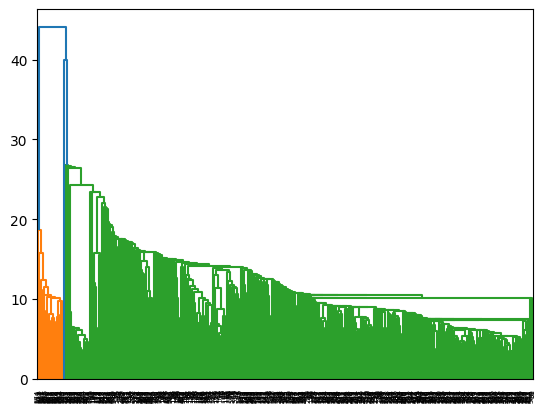

ValueError: Image size of 1838427x17037 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 400x500 with 1 Axes>

In [12]:
# leaf_values = np.array([[1,2,3,10,5,6,19,3.5,30]]).T
# leaf_colors = np.array([[1,0,0], [0,1,0], [0,0,1], [0,0,1]])

# linkage_matrix = np.array([[0,1,1,2],    # link 1 avg = 4.5
#                            [2,3,1.5,3]]) # link 2 avg = 5.5
# linkage_matrix = linkage(leaf_values, method='ward')

ddata = dendrogram(Z)#, link_color_func=lambda id: link_colors[id])

# link_labels = create_link_values(Z, leaf_values[ddata['leaves']])
# link_colors = create_link_values(linkage_matrix, leaf_colors, merge_function=blend_colors)
# # converts to matplotlib colors
# link_colors = [mcolors.to_hex(color) for color in link_colors]

cluster_labels = [c[5] for c in complete_clusters]

plt.figure(figsize=(4, 5))

for icoord, dcoord, label in zip(ddata['icoord'], ddata['dcoord'], cluster_labels):
    x = 0.5 * sum(icoord[1:3])
    y = dcoord[1]
    plt.text(x, y, label, va='center', ha='center', size=10)


plt.show()

# GEOJSON TIME

In [ ]:
def format_geojson_layer(rows):
    features = []
    
    for row in rows:
        # Extract x, y location and RGB values from coords_rgb
        x, y = row[:2]
        rgb = row[2:5]
        label = row[5]
        
        # Create a GeoJSON feature for each label
        feature = {
            "type": "Feature",
            "properties": {
                "label": label,
                "color": f"rgb({rgb[0]}, {rgb[1]}, {rgb[2]})"
            },
            "geometry": {
                "type": "Point",
                "coordinates": [x, y]
            }
        }
        
        features.append(feature)
    
    # Create the GeoJSON object
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    return json.dumps(geojson, indent=4)

In [ ]:
file_layer = format_geojson_layer(leaf_values)
with open("data/layers/complete/final_layer.geojson", "w") as f:
    f.write(file_layer)

# split complete_clusters by cluster (index 6)
cluster_layers = []
for i in range(max_layers):
    cluster_layers.append(format_geojson_layer([row for row in complete_clusters if row[6] == i]))

for i, layer in enumerate(cluster_layers):
    with open(f"data/layers/complete/layer{i}.geojson", "w") as f:
        f.write(layer)

TODO:
- Spread points out
- Figure out layers (less layers?)
- Use summaries of file names for initial summaries
- Make GPT not mention the weights or anything else, just summary. Don't say None as well. 
- Be more general with summaries?